# **REGRESSÃO LOGÍSTICA**
*   ### **Case**: *Livraria*



### Instalação de bibliotecas

In [1]:
# As bibliotecas utilizadas neste notebook já vêm pré-instaladas no Google Colab

### Carregamento de bibliotecas

In [2]:
from IPython.display import display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf                                           # Ajuste de modelos de regressão
from statsmodels.stats.outliers_influence import variance_inflation_factor      # Cálculo do VIF
from sklearn.metrics import roc_auc_score, roc_curve                            # Cálculo do KS e AUC

### Leitura das bases de dados

In [3]:
dados_estoque      = pd.read_table("../Dados/Livraria_Estoque.txt", sep = "\t")
dados_concorrencia = pd.read_table("../Dados/Livraria_Concorrencia.txt", sep = "\t")

### Cruzamento das bases de dados

In [4]:
# Criação de coluna 'flag_concorrente_vende' na 'dados_estoque' que assume 1 quando o concorrente vende o título ou 0 caso contrário
dados_estoque['flag_concorrente_vende'] = dados_estoque['id_titulo'].isin(dados_concorrencia['id_titulo']).astype(int)

### Visualização da base de dados

In [5]:
display(dados_estoque)

,id_titulo,categoria,qtde_paginas,edicao,tipo_capa,densidade_papel,cor,ano,preco,flag_concorrente_vende
0,1,Autoajuda,462,Reedicao,Flexivel,Baixa,Preto,Até 2017,72.49,1
1,2,Artes,559,Reedicao,Dura,Alta,Preto,Até 2017,68.58,1
2,3,Artes,475,Reedicao,Dura,Alta,Cores,2018-2020,69.57,0
3,4,Autoajuda,65,Original,Flexivel,Baixa,Preto,2021-2023,32.66,0
4,5,Infantil,560,Reedicao,Flexivel,Baixa,Cores,2018-2020,64.10,1
...,...,...,...,...,...,...,...,...,...,...
16995,16996,Autoajuda,194,Reedicao,Flexivel,Baixa,Preto,2021-2023,30.33,0
16996,16997,Culinaria,573,Original,Flexivel,Baixa,Cores,2018-2020,60.26,0
16997,16998,Culinaria,608,Original,Flexivel,Alta,Cores,2021-2023,77.59,1
16998,16999,Ciencias,485,Reedicao,Flexivel,Baixa,Preto,Até 2017,71.57,1


### Análise bivariada: variável resposta vs. variáveis explicativas

*Boxplots para variáveis explicativas quantitativas*


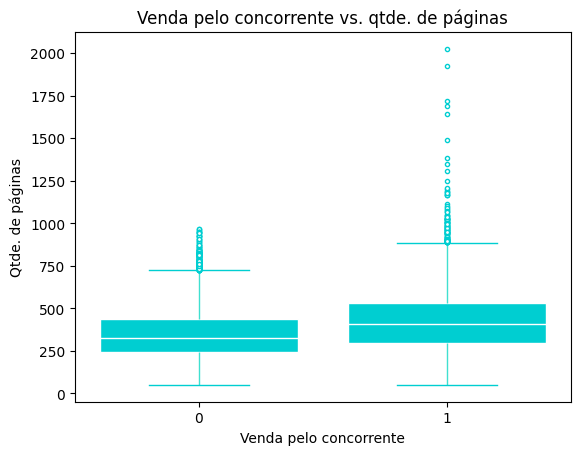

In [6]:
sns.boxplot(y = 'qtde_paginas',
            x = 'flag_concorrente_vende',
            data = dados_estoque,
            width = 0.8,
            boxprops = {'facecolor':'darkturquoise', 'edgecolor':'white'},
            whiskerprops = {'color':'turquoise'},
            capprops     = {'color': 'darkturquoise'},
            medianprops  = {'color':'white'},
            flierprops   = {'markerfacecolor': 'white', 'markeredgecolor': 'darkturquoise', 'marker': 'o', 'markersize': 3, 'color': 'turquoise', 'linestyle': 'none'})

plt.title('Venda pelo concorrente vs. qtde. de páginas')
plt.ylabel('Qtde. de páginas')
plt.xlabel('Venda pelo concorrente')
plt.show()

*Tabelas de frequências para variáveis explicativas qualitativas*

In [7]:
# Categoria
(pd.crosstab(dados_estoque['categoria'], dados_estoque['flag_concorrente_vende'], dropna = False, normalize = 'index') * 100).round(1)

flag_concorrente_vende,0,1
categoria,,
Artes,56.7,43.3
Autoajuda,60.5,39.5
Biografia,46.2,53.8
Ciencias,51.2,48.8
Culinaria,55.7,44.3
Espiritualidade,60.9,39.1
Gestao,55.0,45.0
Historia,60.6,39.4
Infantil,48.3,51.7


In [8]:
# Edição
(pd.crosstab(dados_estoque['edicao'], dados_estoque['flag_concorrente_vende'], dropna = False, normalize = 'index') * 100).round(1)

flag_concorrente_vende,0,1
edicao,,
Original,55.2,44.8
Reedicao,53.2,46.8


In [9]:
# Tipo de capa
(pd.crosstab(dados_estoque['tipo_capa'], dados_estoque['flag_concorrente_vende'], dropna = False, normalize = 'index') * 100).round(1)

flag_concorrente_vende,0,1
tipo_capa,,
Dura,44.0,56.0
Flexivel,57.9,42.1


In [10]:
# Densidade do papel
(pd.crosstab(dados_estoque['densidade_papel'], dados_estoque['flag_concorrente_vende'], dropna = False, normalize = 'index') * 100).round(1)

flag_concorrente_vende,0,1
densidade_papel,,
Alta,40.3,59.7
Baixa,59.3,40.7


In [11]:
# Cor
(pd.crosstab(dados_estoque['cor'], dados_estoque['flag_concorrente_vende'], dropna = False, normalize = 'index') * 100).round(1)

flag_concorrente_vende,0,1
cor,,
Cores,48.5,51.5
Preto,55.5,44.5


In [12]:
# Ano
(pd.crosstab(dados_estoque['ano'], dados_estoque['flag_concorrente_vende'], dropna = False, normalize = 'index') * 100).round(1)

flag_concorrente_vende,0,1
ano,,
2018-2020,72.3,27.7
2021-2023,69.4,30.6
Até 2017,28.1,71.9


### Modelo de regressão logística múltipla

*Ajuste do modelo*

In [13]:
modelo = smf.logit('flag_concorrente_vende ~ categoria + qtde_paginas + edicao + tipo_capa + densidade_papel + cor + ano',
                   data = dados_estoque).fit()

print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.535493
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     flag_concorrente_vende   No. Observations:                17000
Model:                              Logit   Df Residuals:                    16981
Method:                               MLE   Df Model:                           18
Date:                    Thu, 10 Oct 2024   Pseudo R-squ.:                  0.2238
Time:                            22:55:09   Log-Likelihood:                -9103.4
converged:                           True   LL-Null:                       -11727.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.6841 

*Avaliação de colinearidade*

In [14]:
vif = pd.DataFrame({
    "Variável": modelo.model.exog_names,
    "VIF": [variance_inflation_factor(modelo.model.exog, i) for i in range(modelo.model.exog.shape[1])]
})

print(vif)

                        Variável        VIF
0                      Intercept  37.422961
1         categoria[T.Autoajuda]   3.428177
2         categoria[T.Biografia]   2.091180
3          categoria[T.Ciencias]   3.086914
4         categoria[T.Culinaria]   2.556959
5   categoria[T.Espiritualidade]   2.521657
6            categoria[T.Gestao]   3.681950
7          categoria[T.Historia]   2.577776
8          categoria[T.Infantil]   3.041178
9        categoria[T.Literatura]   3.457483
10    categoria[T.Universitario]   1.834825
11           categoria[T.Viagem]   1.507914
12            edicao[T.Reedicao]   1.004446
13         tipo_capa[T.Flexivel]   1.192221
14      densidade_papel[T.Baixa]   1.083885
15                  cor[T.Preto]   1.123409
16              ano[T.2021-2023]   1.251259
17               ano[T.Até 2017]   1.254807
18                  qtde_paginas   1.190334


### Aplicação do modelo e definição de resposta predita

In [15]:
# Aplicação do modelo na base (criação de uma nova coluna chamada "probabilidade")
dados_estoque['probabilidade'] = modelo.predict()

In [16]:
# Definição de ponto de corte (padrão: % de 1's na amostra)
ponto_corte = dados_estoque['flag_concorrente_vende'].mean()
ponto_corte

np.float64(0.45941176470588235)

In [17]:
# Definição da resposta predita pelo modelo (criação de uma nova coluna chamada "predito")
dados_estoque['predito'] = (dados_estoque['probabilidade'] > ponto_corte).astype(int)

### Análise de desempenho

In [18]:
# Tabela de classificação
tabela = pd.crosstab(dados_estoque['flag_concorrente_vende'], dados_estoque['predito'])

In [19]:
# Acurácia
(tabela.iloc[0,0] + tabela.iloc[1,1]) / tabela.sum().sum()

np.float64(0.7238235294117648)

In [20]:
# Especificidade
tabela.iloc[0,0] / (tabela.iloc[0,0] + tabela.iloc[0,1])

np.float64(0.7205658324265506)

In [21]:
# Sensibilidade
tabela.iloc[1,1] / (tabela.iloc[1,0] + tabela.iloc[1,1])

np.float64(0.7276568501920615)

In [22]:
# KS
fpr, tpr, _ = roc_curve(dados_estoque['flag_concorrente_vende'], dados_estoque['probabilidade'])
max(tpr - fpr)

np.float64(0.44887514820847135)

In [23]:
# AUC
roc_auc_score(dados_estoque['flag_concorrente_vende'], dados_estoque['probabilidade'])

np.float64(0.8050443406307864)

### Exemplo de uso (aplicação) do modelo

In [24]:
# Criação de base de dados com um novo título
# Obs.: os nomes das colunas devem ser idênticos aos da base utilizada para construção do modelo
novos_dados = pd.DataFrame({
    'categoria'      : ['Autoajuda'],
    'qtde_paginas'   : [500],
    'edicao'         : ['Original'],
    'tipo_capa'      : ['Flexivel'],
    'densidade_papel': ['Baixa'],
    'cor'            : ['Preto'],
    'ano'            : ['2021-2023']
})

In [25]:
# Aplicação do modelo
modelo.predict(novos_dados)

0    0.232391
dtype: float64